<img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width="80%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-398/578 Introducción al aprendizaje automático</h1>

<h4 align='center'><b>Tarea 3: Redes neuronales y ensamblados.</b></h4>


<h6 align='center'><b>Profesor:</b> Carlos Valle</h6>
<h6 align='center'><b>Ayudante:</b> Jean Aravena</h6>



<hr style="height:2px;border:none"/>

# **Tarea 3 📃**

## **Temas**  

* Redes neuronales.
* Ensamblados.
* Random Forest, XGBoost, CatBoost.


## **Formalidades** 

* Equipos de trabajo de 2 personas.
* El entregable debe ser este mismo Jupyter Notebook incluyendo todos los resultados, los gráficos realizados y las respuestas a las preguntas. 
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el Jupyter Notebook que entregarán.
* Formato de entrega: Subir a aula el Jupyter Notebook con el nombre NombreGrupo_Tarea_3_ML_2022_1
* Fecha de entrega y presentaciones: 22 de Julio. Hora límite de entrega: 14:30.
 

<hr style="height:2px;border:none"/>

La tarea se divide en 3 partes:

1.   Redes Neuronales.
2.   Ensamblados.
3.   Desafío.


La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, solo son guías y pueden ser creativos al momento de resolver la tarea. También en algunas ocasiones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.

Recuerden intercalar su código con comentarios y utilizar celdas Markdown en caso de que sea necesario para realizar análisis, escribir fórmulas o realizar explicaciones que les parezca relevante para justificar sus procedimientos. 

Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en sí, en cambio la argumentación detrás de la elección será lo más ponderado.

*Se recomienda el uso de Google Colab para realizar la tarea.*

# Librerias 📚
 

Agregar cualquier otra librería que requiera para el desarrollo de la tarea.

In [79]:
!pip install -q -U catboost
!pip install -q -U keras-tuner

In [80]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, Loss
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from tensorflow.keras import backend as K


sns.set_theme()
warnings.filterwarnings('ignore')

# Utils ⚙️  

In [81]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Path to your folder
path = '/content/drive/MyDrive/Machine Learning/Data'

Mounting your Google Drive ...


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Set all seed.
def set_all_seed(seed=0):
  """Set the same seed for all the libraries that we use."""
  np.random.seed(seed)
  tf.random.set_seed(seed)

# Elegir cualquier semilla y siempre que se pueda utilizarla
# random_state = SEED

SEED = 2022

set_all_seed(seed=SEED)

# 1.1) Redes Neuronales 💣

<img src="https://drive.google.com/uc?id=12fnVpIB_qDJx_OVty7aWT1Ftw2o9r1Hl" width="60%"/>

[Referencia](https://purnasaigudikandula.medium.com/a-beginner-intro-to-neural-networks-543267bda3c8)

Para la creación de redes neuronales generalmente existen dos bandos:


*   `Pytorch`
*   `Tensorflow`

Por un lado, tenemos a `Pytorch` que es mayormente utilizado en investigación y por otro lado tenemos a `Tensorflow` que es mayormente utilizado en la industria. Ambos tienen la misma capacidad de abstracción y ambos son ampliamente aceptados y poseen una gran comunidad que los respalda.

Si nos vamos a una página bastante conocida como lo es [Papers With Code](https://paperswithcode.com/) podemos ver que desde la fecha `2018-03-01` hasta `2022-03-31` existe una tendencia creciente para el uso de `Pytorch` en términos de utilización en nuevos papers, es por ello por lo que en general si se va a realizar investigación se recomienda `Pytorch`, pero ambos son útiles y si sabes uno se hace más fácil cambiarse de uno a otro. En introducción a las redes neuronales se utiliza `Tensorflow`, es por ello que también emplearemos ese framework en esta tarea, pero como se mencionó anteriormente no importa mucho cual aprendas porque te puedes cambiar cuando sea necesario.


<img src="https://drive.google.com/uc?id=1xVqc0kPI1TXmhMmsMJnxOiUsGAaqiYGP" width="80%"/>


[Referencia](https://paperswithcode.com/trends)

## Carga y exploración de la data

In [ ]:
# Cargar la data que corresponde a un csv
path = ""
PATH_TO_CSV = os.path.join(path, "tarea_3_house_price.csv")
df_data = pd.read_csv(PATH_TO_CSV)

<img src="https://drive.google.com/uc?id=13v7iUc8zmqlQ46aMfbtQ5dIEtDcdiNYx" width="50%"/>


Para la primera parte de la tarea trabajaremos con un dataset muy clásico en ML el cual es [House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction), que viene de `Kaggle`.

La data corresponde a 21.613 instancias las cuales tienen relación con precios de casas en dólares.

El dataset cuenta con 20 features las cuales están diseñadas para identificar ciertos patrones y con ello tratar de predecir el precio de una casa.

Features:

* `id`: Unique ID for each home sold
* `date`: Date of the home sale
* `bedrooms`: Number of bedrooms
* `bathrooms`: Number of bathrooms, where .5 accounts for a room with a toilet  but no shower
* `sqft_living`: Square footage of the apartments interior living space
* `sqft_lot`: Square footage of the land space
* `floors`: Number of floors
* `waterfront`: A dummy variable for whether the apartment was overlooking the waterfront or not
* `view`: An index from 0 to 4 of how good the view of the property was
* `condition`: An index from 1 to 5 on the condition of the apartment,
* `grade`: An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
* `sqft_above`: The square footage of the interior housing space that is above ground level
* `sqft_basement`: The square footage of the interior housing space that is below ground level
* `yr_built`: The year the house was initially built
* `yr_renovated`: The year of the house’s last renovation
* `zipcode`: What zipcode area the house is in
* `lat`: Lattitude
* `long`: Longitude
* `sqft_living15`: The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15`: The square footage of the land lots of the nearest 15 neighbors

Target:
* `price`: Price of each home sold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Como es usual realice un pequeño EDA (Exploratory Data Analysis). Comente los resultados obtenidos** [2 Pts]

##Análisis datos

In [ ]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Primero se analizarán todas las variables que se sospecha que tengan una correlación directa con el precio.

###Piezas

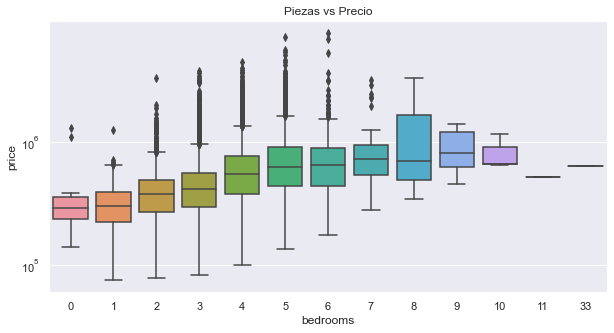

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
plt.yscale('log')
sns.boxplot(x="bedrooms", y="price", data=df_data)
plt.title("Piezas vs Precio")
plt.show()

Se puede ver que el número de piezasb tiene una relación directa con el precio entre 0 y 7 piezas. Para 8 o más el valor se vuelve menos predecible.

###Baños

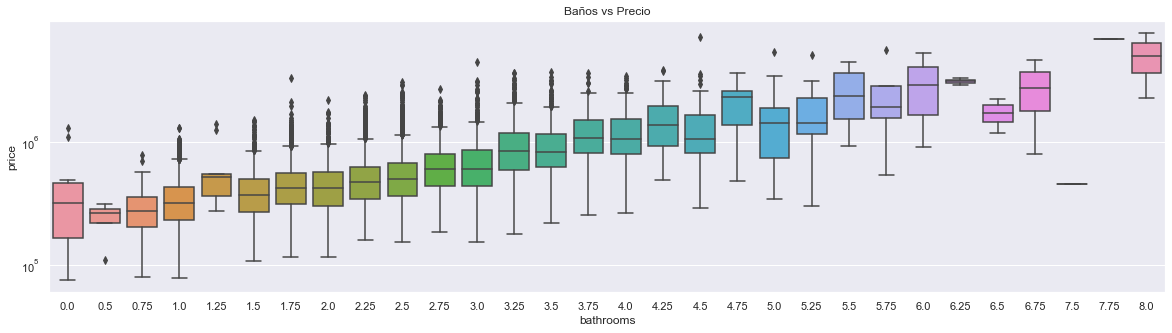

In [ ]:
f, ax = plt.subplots(figsize=(20, 5))
plt.yscale('log')
sns.boxplot(x="bathrooms", y="price", data=df_data)
plt.title("Baños vs Precio")
plt.show()

Se repite un patrón similar al de las piezas, con una relación relativamente directa para casas con entre 0.5 y 4.25 baños

###Tamaño Living y Terreno

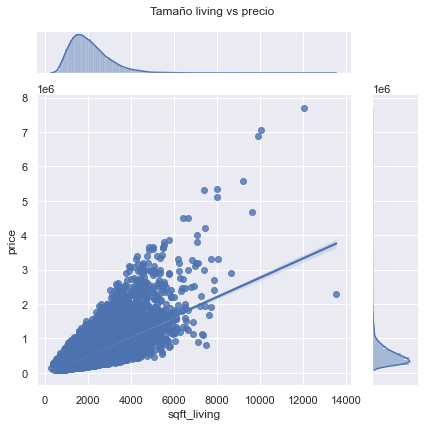

In [ ]:
p = sns.jointplot("sqft_living", "price", data=df_data, kind='reg');
p.fig.suptitle("Tamaño living vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92) 

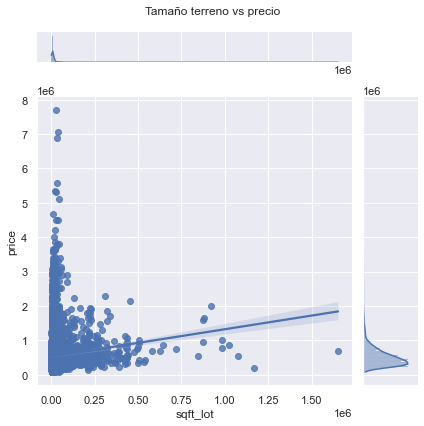

In [ ]:
p = sns.jointplot("sqft_lot", "price", data=df_data, kind='reg');
p.fig.suptitle("Tamaño terreno vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92) 

En ambos se puedde ver una relación directa entre el tamaño y el precio. Sin embargo, existe una gran cantidad de outliers para terrenos pequeños.

###Pisos

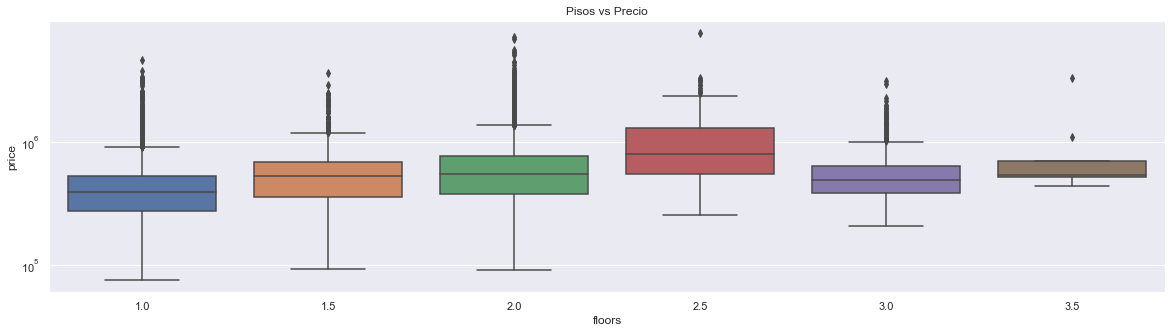

In [ ]:
f, ax = plt.subplots(figsize=(20, 5))
plt.yscale('log')
sns.boxplot(x="floors", y="price", data=df_data)
plt.title("Pisos vs Precio")
plt.show()

Aquí la relación es un poco tenue, y se mantiene solo hasta los 2.5 pisos.

### Vista y Condición

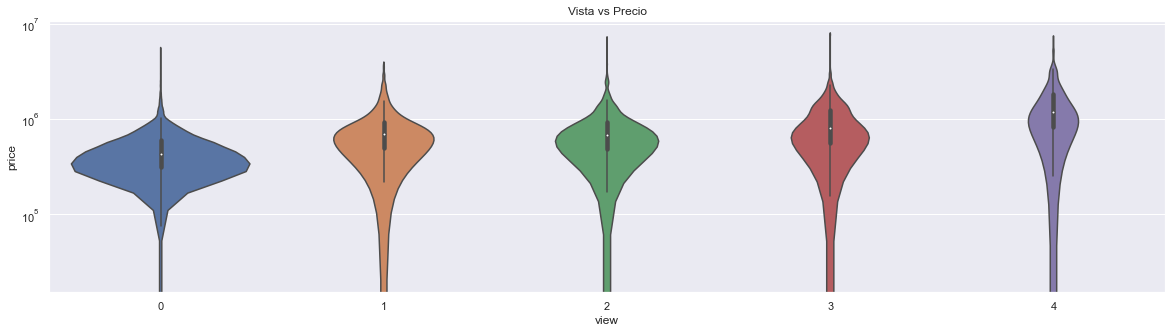

In [ ]:
f, ax = plt.subplots(figsize=(20, 5))
plt.yscale('log')
sns.violinplot(x="view", y="price", data=df_data)
plt.title("Vista vs Precio")
plt.show()

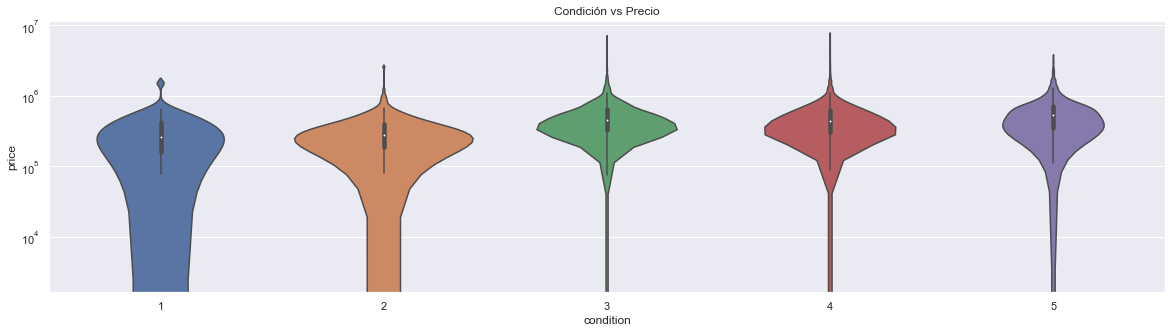

In [ ]:
f, ax = plt.subplots(figsize=(20, 5))
plt.yscale('log')
sns.violinplot(x="condition", y="price", data=df_data)
plt.title("Condición vs Precio")
plt.show()

Las relaciones del precio con la vista y condición de las casas es más tenue de lo inicialmente esperado. Caba destacar que las casas con mala condicion (1 o 2) tienen una alta frecuencia de precios bajos, a pesar de que sus mediene no esté tan lejos de la de casas con puntaje 3.

###Puntuación

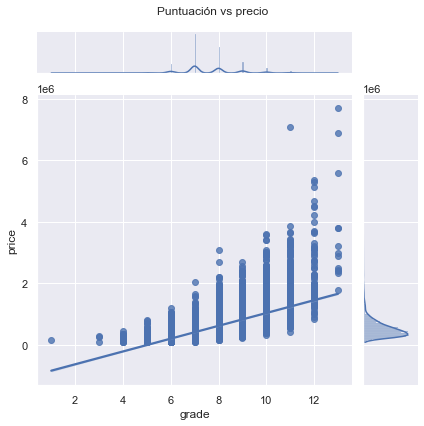

In [ ]:
p = sns.jointplot("grade", "price", data=df_data, kind='reg');
p.fig.suptitle("Puntuación vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92)

Aquí la relación entre puntuación y precio es bastante clara.

### Tamaño pisos superiores y subterraneo

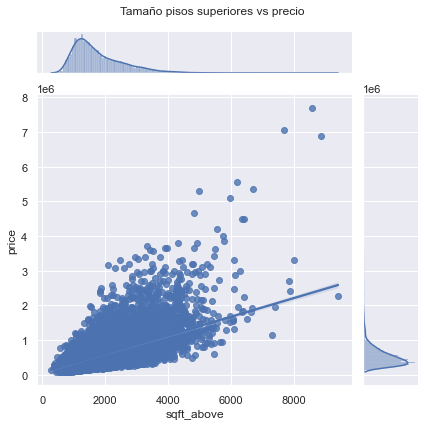

In [ ]:
p = sns.jointplot("sqft_above", "price", data=df_data, kind='reg');
p.fig.suptitle("Tamaño pisos superiores vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92)

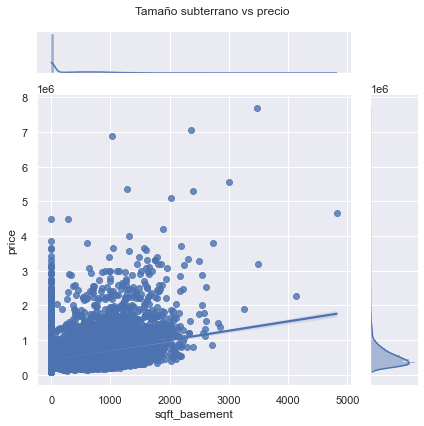

In [ ]:
p = sns.jointplot("sqft_basement", "price", data=df_data, kind='reg');
p.fig.suptitle("Tamaño subterrano vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92)

La relación es más clara para los pisos superiores, mientras que para el tamaño de los subterraneos, si bien hay una relación con el precio, también existe una alta cantidad de outliers.

###Tamaño vecinos

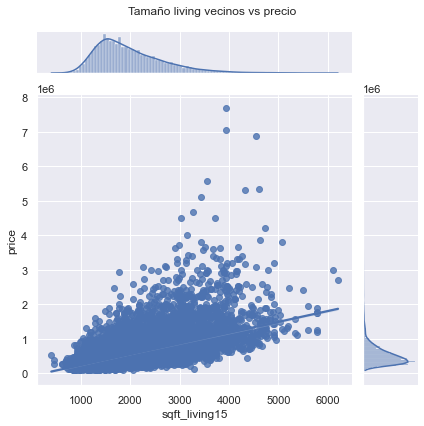

In [ ]:
p = sns.jointplot("sqft_living15", "price", data=df_data, kind='reg');
p.fig.suptitle("Tamaño living vecinos vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92)

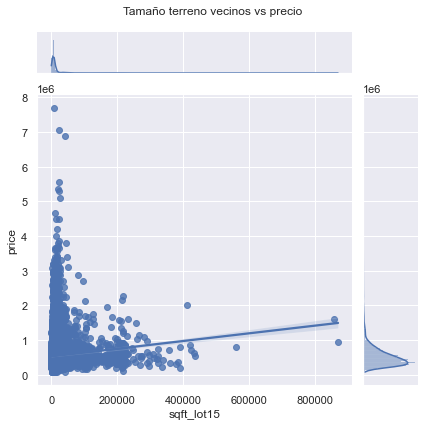

In [ ]:
p = sns.jointplot("sqft_lot15", "price", data=df_data, kind='reg');
p.fig.suptitle("Tamaño terreno vecinos vs precio")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.92)

Ambos gráficos son muy similares a los de tamaños para la casa misma, por lo que se espera que las casas en un miusmo vecindario tengan valores similares (y tamaños similares).

###Waterfront

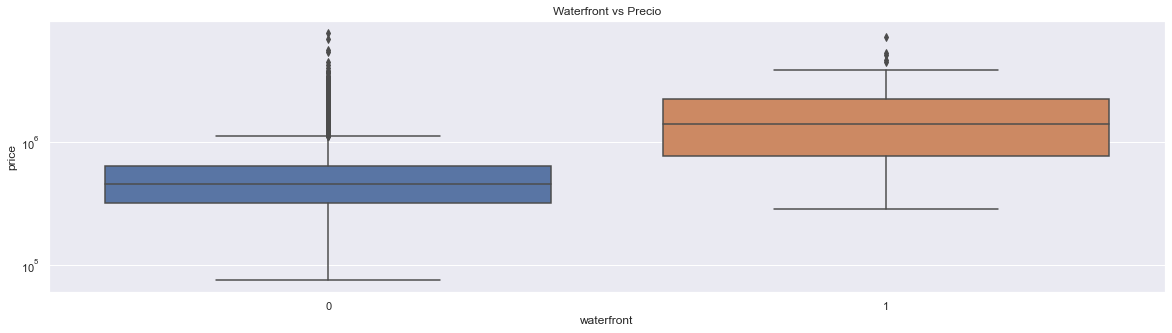

In [ ]:
f, ax = plt.subplots(figsize=(20, 5))
plt.yscale('log')
sns.boxplot(x="waterfront", y="price", data=df_data)
plt.title("Waterfront vs Precio")
plt.show()

Los departamentos o casas con vista al mar tienen un valor considerablemente más alto en promedio que los que no.

##División datos y preprocesamiento

**Divida la data en training/validation/testing considerando un split 80/10/10 y realice un preprocesamiento a la data** [2 Pts] 

Viendo las features del dataset, la única que no se considerara útil para el entrenamiento es el `id`, por lo que se eliminara dicha columna para el training, además de separar la columna `price`, ya que es el target. 

En cuanto al resto, se usara standard scaler para `sqft_living, sqft_lot, sqft_above. sqft_basement, sfqt_living15 y sqft_lot15`, ya que indican valores continuos que indicant un tamaño.

Se usará minmax scaler para `lat, long y zipcode`, ya que los valores varían mucho para un encoding con labels, y se espera una distribución diferente a una normal.

Las variables `bedrooms, bathrooms, floors, view, condition, grade, yr_built y yr_renovated` son discretas, con característica ordinal, por lo que se usará ordinal encoding.

Como `waterfront` es una varialbe binaria, se usará label encoding.

Finalmente, `date` se dividirá en `yr_sold y month sold`, las cuales tendrán ordinal y cos/sin encoding respectivamente, ya que la primera es ordinal, mientras que la segunda es cíclica (`month_sold` quedará como `cos_month y sin_month`). 

In [ ]:
StandardList = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15' , 'sqft_lot15']
MinMaxList = ['lat', 'long' , 'zipcode']
OrdinalList = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'yr_sold']
LabelList = ['waterfront']
CycleList = ['cos_month', 'sin_month']

def preprocess_month(df, column):
  MONTHS_IN_YEAR = 12
  df['sin_month'] = np.sin(2 * np.pi * df[column] / MONTHS_IN_YEAR)
  df['cos_month'] = np.cos(2 * np.pi * df[column] / MONTHS_IN_YEAR)
  df.drop(columns=[column], inplace=True)
  return df

def process_data(df_data):
    #process the date column
    yr_col = df_data['date'].copy()
    yr_col = yr_col.apply(lambda x: int(x[0:4]))
    month_col = df_data['date'].copy()
    month_col = month_col.apply(lambda x: int(x[4:6]))

    #Add new columns and drop unnecessary ones
    df_data['yr_sold'] = yr_col
    df_data['month_sold'] = month_col
    preprocess_month(df_data, 'month_sold')
    df_data = df_data.drop(columns=['id', 'date'], inplace=False)

    #split into train, validation and test data
    df_train, df_not_train = train_test_split(df_data, test_size=0.2, random_state=SEED)
    df_val, df_test = train_test_split(df_not_train, test_size=0.5, random_state=SEED)

    #Standard Scale
    scaler = StandardScaler()
    for col in StandardList: 
      scaler.fit(df_train[[col]])
      df_train[[col]] = scaler.transform(df_train[[col]])
      df_val[[col]] = scaler.transform(df_val[[col]])
      df_test[[col]] = scaler.transform(df_test[[col]])

    #MinMax Scale
    scaler = MinMaxScaler()
    for col in MinMaxList: 
      scaler.fit(df_train[[col]])
      df_train[[col]] = scaler.transform(df_train[[col]])
      df_val[[col]] = scaler.transform(df_val[[col]])
      df_test[[col]] = scaler.transform(df_test[[col]])

    #Ordinal Encode
    encoder = OrdinalEncoder()
    for col in OrdinalList:
      encoder.fit(df_data[col].values.reshape(-1,1))
      df_train[col] = encoder.transform(df_train[col].values.reshape(-1,1))
      df_val[col] = encoder.transform(df_val[col].values.reshape(-1,1))
      df_test[col] = encoder.transform(df_test[col].values.reshape(-1,1))

    #Label Encode
    encoder = LabelEncoder()
    for col in LabelList:
      encoder.fit(df_train[col])
      df_train[col] = encoder.transform(df_train[col])
      df_val[col] = encoder.transform(df_val[col])
      df_test[col] = encoder.transform(df_test[col])

    return df_train, df_val, df_test

def split_data(df):
    X = df.drop(columns='price', inplace=False)
    y = df['price'].to_numpy(copy=True)
    return X, y

df_train, df_val, df_test = process_data(df_data)

## Formas de crear una red neuronal

Existen tres formas distintas para crear una red neuronal utilizando `Tensorflow`:


1.   `Sequential API`
2.   `Functional API`
3.   `Model Subclassing`


Ordenados de menor a mayor en términos de flexibilidad, pero con el costo de trabajar a más bajo nivel.




### ¿Cómo preparar la data para utilizarla en una red neuronal?


Antes de crear la red aprenderemos a cómo preparar la data para ser utilizada posteriormente. Si bien existen múltiples formas, veremos el estándar que tiene Google en sus [tutoriales](https://www.tensorflow.org/tutorials) de `Tensorflow`. Lo cual consiste en hacer uso de [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/DatasetSpec)

**Siga los pasos indicados a continuación considerando la data** [1 Pts]

Separe cada dataframe en features y target.


In [ ]:
X_train, y_train = split_data(df_train)
X_val, y_val = split_data(df_val)
X_test, y_test = split_data(df_test)

Crear los dataset de entrenamiento, validacion y testing utilizando `tf.data.Dataset.from_tensor_slices` considerando como parámetro la tupla X, y. Ejemplo: `tf.data.Dataset.from_tensor_slices(X_train.values, y_train.values)`


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Podemos mostrar la estructura del dataset con un print o bien llamando a la variable.

In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(21,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

También podemos mostrar un elemento en específico del dataset.

In [ ]:
for (X, y) in train_dataset:
  print(X)
  print(y)
  break

tf.Tensor(
[ 3.00000000e+00  1.20000000e+01  5.42513540e-01 -1.26326421e-01
  1.00000000e+00  0.00000000e+00  1.00000000e+00  3.00000000e+00
  7.00000000e+00 -3.44500603e-02  1.18620832e+00  7.80000000e+01
  0.00000000e+00  1.31313131e-01  6.03989062e-01  3.86212625e-01
  2.20573173e-01 -8.63801601e-02  1.00000000e+00  1.00000000e+00
  6.12323400e-17], shape=(21,), dtype=float64)
tf.Tensor(688888.0, shape=(), dtype=float64)


`Tensorflow` funciona en base a tensores. Un `tensor` no es más ni menos que una matriz con cero o más dimensiones. Un `tensor` de dimension cero se llama escalar


En este caso vamos a mostrar tensores de 0, 1 y 2 dimensiones para comprender como varia el valor de shape en cada caso.

In [ ]:
tensor_zero_dimension = tf.Variable(1, tf.int32)
tensor_zero_dimension 

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>

Si el `tensor` es un escalar entonces vamos a tener `shape=()`.

In [ ]:
tensor_one_dimension = tf.Variable([2, 3], tf.int32)
tensor_one_dimension

<tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([2, 3])>

Si el `tensor` es de una dimension vamos a tener `shape=(2, )` lo que indica que tenemos un `tensor` con una dimension y dos elementos.

In [ ]:
tensor_two_dimension = tf.Variable([[1, 2], [2, 3]], tf.int32)
tensor_two_dimension

<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [2, 3]])>

Si el `tensor` es de dos dimensiones vamos a tener `shape=(2, 2)` lo que indica que tenemos un `tensor` con dos dimension y dos elementos.


En conclusión si tenemos `shape=(x, y)` el valor `x` corresponde a la cantidad de elementos que existe en el tensor e `y` corresponde a la dimensionalidad de este. Cuando `shape=()` significa que tenemos un escalar lo que es igual a tener un tensor de dimensionalidad cero.

En caso de que queramos obtener el valor de un `Tensor` como usualmente se aprecia en `numpy`, tenemos que utilizar `X.numpy()` o bien `y.numpy()`.

In [ ]:
for (X, y) in train_dataset:
  print(X.numpy())
  print(y.numpy())
  break

[ 3.00000000e+00  1.20000000e+01  5.42513540e-01 -1.26326421e-01
  1.00000000e+00  0.00000000e+00  1.00000000e+00  3.00000000e+00
  7.00000000e+00 -3.44500603e-02  1.18620832e+00  7.80000000e+01
  0.00000000e+00  1.31313131e-01  6.03989062e-01  3.86212625e-01
  2.20573173e-01 -8.63801601e-02  1.00000000e+00  1.00000000e+00
  6.12323400e-17]
688888.0


Continuando con el tutorial de la preparación de la data, el primer paso es tener el dataset en la forma de tupla `(X, y)`. Como ya tenemos el dataset de la forma correcta, el siguiente paso es preparar el dataset para ser usado por la red neuronal. Para ello utilicen la siguiente funcion:

In [ ]:
def preprocess_dataset(dataset, batch_size, size):
  """Preprocess dataset.

    :param dataset: Dataset para prepararlo para el entrenamiento
    :type dataset: tensorflow.python.data.ops.dataset_ops.TensorSliceDataset
    :param batch_size: Tamano del batch a utilizar para entrenamiento
    :type batch_size: int
    :param table_name: Tamano del dataset
    :type table_name: int
    :return: Dataset listo para ser usado por la red neuronal
    :rtype: tensorflow.python.data.ops.dataset_ops.TensorSliceDataset
  """

  AUTOTUNE = tf.data.AUTOTUNE

  dataset = dataset.shuffle(size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=AUTOTUNE)
  dataset = dataset.cache()

  return dataset

**De que sirve la funcion anterior** [1 Pts] 




`Comentario`: Sirve para:
1.   Setear el `batch size`, que es la cantidad de muestras que pasarán a la vez por .
2.   Setear el dataset para que elija el buffer del `prefetching` (datos del batch siguiente que se leerán mientras se ejecuta el paso actual) de manera dinámica con `AUTOTUNE` de tensorflow.
3.   Reordena los datos del dataset de manera aleatoria, usando el buffer `size`.

In [ ]:
dataset = preprocess_dataset(train_dataset, 100, SEED)

**Explique el significado del tamano del batch (`batch size`) en la implementación moderna del algoritmo BP (`back-propagation`). ¿Qué valor recomendaría si su conjunto de entrenamiento es de 10.000 ejemplos? ¿Qué valor recomendaría si su conjunto de entrenamiento es de 1.000.000 de ejemplos?** [1 Pts]

`Respuesta:` `batch size` es la cantidad de muestras que pasarán a la vez por la red. Este valor no depende del tamaño del dataset, sino que de la capacidad del computador usado, y el tiempo en el que se quiere entrenar la red, por lo que en ambos casos recomendaría el mismo batch-size, el cual dependera del computador y tiempo disponible.

Finalmente, tenemos listo el dataset para ser utilizado por la red neuronal.

### Sequential API

Crear y entrenar una red neuronal que tenga:


*   1 capa de entrada (Identifique que dimensiones debería tener)
*   3 capas ocultas con 16 neuronas cada una y con funcion de activación `ReLu`
*   1 capa de salida con 1 neurona con funcion de activación por defecto (`linear`)


Usando [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) [2 Pts]




*Para ello se puede apoyar en la función [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) de `Tensorflow`.*

```
model = Sequential([
  Input(..., name=''),
  Dense(units=128, activation='relu', ..., name=''),
  Dense(units=128, activation='relu', ..., name=''),
  ...
  Dense(units=1, ..., name='')
])
```

Y compile el modelo utilizando model.compile de `Tensorflow` considerando como base el siguiente ejemplo:

```
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
```
Para mayor información se recomienda revisar el siguiente [link](https://www.tensorflow.org/guide/keras/train_and_evaluate#the_compile_method_specifying_a_loss_metrics_and_an_optimizer).

Utilizar:
* `optimizer` = `Adam(learning_rate=1e-3)` con los parámetros por defecto
* `loss` = `Mean Squared Error`
* `metrics` = `Mean Squared Error`

In [ ]:
model = Sequential(
    [
        Input(shape=(21,), name='input'),
        Dense(16, activation="relu", name="layer1"),
        Dense(16, activation="relu", name="layer2"),
        Dense(16, activation="relu", name="layer3"),
        Dense(1, name="output"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=MeanSquaredError(),
    metrics=[MeanSquaredError()],
)

**Calcule la cantidad de parámetros entrenables de esta red y luego verifique su resultado utilizando `model.summary()`** (Cuando se pide el número de parámetros explicitar como llego a ese valor, que multiplicaciones o sumas tuvo que realizar) [0.5 Pts]

`Número de Parámetros` = `22*16 + 17*16 + 17*16 + 17*1` = `352 + 272 + 272 + 17`  = `913`.

Para calcular el números de parámetros entrenables se calcula un valor entre cada capa y la siguiente, el cual es `(n+1 * m)` con `n` igual al valor de neuronas en la primera capa usado para el cálculo, y `m` la cantidad de nodos en la siguiente. Se suma 1 a `n`, debido a que se deben considerar los bias de cada capa. 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 16)                352       
                                                                 
 layer2 (Dense)              (None, 16)                272       
                                                                 
 layer3 (Dense)              (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


**Muestre la estructura de la red utilizando la función `tf.keras.utils.plot_model`** [1 Pts]

In [ ]:
tf.keras.utils.plot_model(model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### ¿Cómo crear funciones de perdida?

Para probar los siguientes apartados vamos a crear un dataset muy sencillo que corresponde a 100 datos extraídos de la siguiente ecuación:

$$y = 2x + 1$$

e intentaremos predecir $x=100$, lo cual debería ser $y=201$ o muy cercano a este valor.

In [ ]:
# Create a dummy dataset
x = tf.linspace(start=1, stop=100, num=100)
y = tf.multiply(x, 2) + 1

`Tensorflow` da bastante flexibilidad y podemos crear las funciones de pérdidas que queramos, en este caso creare la funcion de RMSE.


In [ ]:
# With subclassing
class MyCustomRMSEV1(Loss):

  def __init__(self, **kwargs):
    super(MyCustomRMSEV1, self).__init__(**kwargs)

  def call(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    rmse = tf.math.sqrt(mse)
    return rmse

In [ ]:
model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomRMSEV1())
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

1/1 [==============================] - 0s 76ms/step
Prediction [[202.7973]]


In [ ]:
# Without subclassing
def MyCustomRMSEV2():

  def loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    rmse = tf.math.sqrt(mse)
    return rmse

  return loss

In [ ]:
model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomRMSEV2())
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

1/1 [==============================] - 0s 45ms/step
Prediction [[203.00983]]


En la versión que no utiliza subclassign le podemos pasar parámetros adicionales a la funcion, como por ejemplo:


In [ ]:
def MyCustomRMSEV3(factor):

  def loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / factor

  return loss

In [ ]:
model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomRMSEV3(factor=100))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

1/1 [==============================] - 0s 44ms/step
Prediction [[203.00003]]


**Existe una funcion de perdida para regresión llamada Huber, investigar cómo se calcula, impleméntela usando `Tensorflow` y prediga el valor para $x=100$ considerando el dataset dummy creado anteriormente** [1 Pts]




`Huber`: 

$   
L_\delta(y,f(x)) = 
     \begin{cases}
       \frac{1}{2}(y-f(x))^2 &\quad\text{cuando }|y-f(x)|\le \delta\\
       \ \delta |y-f(x)|-\frac{1}{2}\delta^2&\quad\text{en cualquier otro caso} \\ 
     \end{cases}
$

In [ ]:
def MyCustomHuberLoss(delta):

  def loss(y_true, y_pred):
    absolute = tf.reduce_mean(tf.math.abs(y_true - y_pred))
    if absolute < delta:
        return tf.reduce_mean(tf.square(y_pred - y_true))
    else:
        return delta * absolute - 0.5 * delta**2

  return loss

model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomHuberLoss(delta=0.5))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([100.0])}")

1/1 [==============================] - 0s 47ms/step
Prediction [[201.00002]]


#### ¿Cómo crear funciones de activación?

También podemos crear funciones de activación utilizando `Tensorflow`. Para ello se muestra el ejemplo de la funcion de activación sigmoidal.

In [ ]:
def MySigmoid(x):
  return 1/ (1 + tf.math.exp(-x))

model = Sequential([Dense(units=1, input_shape=[1], activation=MySigmoid)])
model.compile(optimizer='adam', loss=MyCustomHuberLoss(delta=0.5))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([100.0])}")

1/1 [==============================] - 0s 56ms/step
Prediction [[1.]]


**Identifique la expresión matemática que computa la funcion de activación `LeakyRelu` e impleméntela utilizando `Tensorflow`. Utilice como funcion de activación `LeakyRelu` con cualquier valor de `alpha` y prediga el valor para $x=100$ considerando el dataset dummy creado anteriormente** [1 Pts]


In [ ]:
def MyLeakyRelu(x, alpha=0.1):
    return K.switch(x >= 0, x, alpha*x)

model = Sequential([Dense(units=1, input_shape=[1], activation=MyLeakyRelu)])
model.compile(optimizer='adam', loss=MyCustomHuberLoss(delta=0.5))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([100.0])}")


1/1 [==============================] - 0s 58ms/step
Prediction [[200.50455]]


`LeakyRelu`:

$   
f_\alpha(y) = 
     \begin{cases}
       \ y &\quad\text{cuando } y\ge0\\
       \ \alpha y&\quad\text{cuando } y < 0 \\ 
     \end{cases}
$

#### ¿Cómo crear capas personalizadas?

Para crear capas personalizadas tenemos que hacer subclassing a la clase `Layer`. En este caso se replica parte de la capa `Dense` que utilizamos anteriormente.

In [ ]:
class MyCustomDenseV1(Layer):

  def __init__(self, units=16, activation=None):
    """Inicializar los atributos de la instancia"""
    super(MyCustomDenseV1, self).__init__()
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    """Crear el 'template' de la capa (pesos)"""
     # Initialize the weights
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(name="kernel",
                        initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),
                        trainable=True)
    b_init = tf.zeros_initializer()
    # Initialize the biases
    self.b = tf.Variable(name="bias",
                         initial_value=b_init(shape=(self.units, ), dtype='float32'),
                         trainable=True)
  
  def call(self, inputs):
    """Definir la operaciones que realiza la capa desde inputs a outputs"""
    return self.activation(tf.matmul(inputs, self.w) + self.b)

In [ ]:
model = Sequential([Input(shape=(1, )), MyCustomDenseV1(units=1)])
model.compile(optimizer=Adam(learning_rate=1e-3), loss=MyCustomRMSEV3(factor=10))
model.fit(x, y, epochs=500, verbose=0)

print(f"Prediction {model.predict([101.0])}")

1/1 [==============================] - 0s 46ms/step
Prediction [[196.21136]]


**Crear una capa densa con el nombre `MyCustomDenseV2` que compute lo siguiente: [1 Pts]
$$y = ax^3 * bx^2 - cx + d $$** 
Esto puede que no tenga mucho sentido en la práctica, es solo para que se familiaricen un poco con el código.

Utilice su capa `MyCustomDenseV2` y prediga el valor para $x=100$ considerando el dataset dummy creado anteriormente

In [ ]:
### START CODE HERE ###


**Calcular la cantidad de parámetros de su modelo anterior. Explicar su resultado** [0.5 Pts]

`Número de parámetros`: 

#### ¿Qué son los callbacks en TensorFlow?

**Existen multiples `Callbacks` dispibles en `Tensorflow` e incluso uno puede crear `Callbacks` personalizados. Defina la utilidad de los `Callbacks` y averiguar cómo funciona el callback [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) y [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint). Finalmente cree una lista con ambos callbacks para posteriormente ser pasados al entrenamiento de la red** [1 Pts]

*   `Callbacks`:
*   `EarlyStopping`:
*   `ModelCheckpoint`:



Para `EarlyStopping` utilice los parámetros `monitor, patience y restore_best_weights`. Elija un valor apropiado para `monitor y patience`, el parámetro `restore_best_weights` déjelo en True.


Para `ModelCheckpoint` utilice los parámetros `filepath, monitor, save_best_only y save_weights_only`. Elija un valor para los parámetros `filepath y monitor`, los parámetros `save_best_only, save_weights_only` déjelos en True.


In [ ]:
### START CODE HERE ###


#### Entrenamiento de la primera red neuronal

Para entrenar una red la forma más sencilla es utilizar el metodo `model.fit`. También se puede personalizar lo que sucede en el model.fit pero eso quedara para el siguiente curso de introducción a las redes neuronales. Si les interesa saber acerca del tema les dejo el siguiente [link](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

Entrene su modelo utilizando `model.fit`. Defina un numero de epoch acorde al problema, utilice los callbacks definidos anteriormente y los dataset (entrenamiento y validacion) que ya tiene listos para ser pasados por la red. Guardar el resultado en una variable, puede ser llamada `history`.

In [ ]:
### START CODE HERE ###


**Grafique las curvas de entrenamiento. Comente el grafico** [1 Pts]

In [ ]:
### START CODE HERE ###


Identifique en que parte de la siguiente figura se encuentra su entrenamiento: 

<img src="https://drive.google.com/uc?id=1kecseaITvJeG45WNePflLn_u3sOYUyq4" width="50%"/>

**En caso de que se encuentre en la parte izquierda o derecha que tiene que recomendaría hacer?** [1 Pts]

`Respuesta`:

**Compute el resultado de su modelo para el conjunto de testing** [1 Pts]

In [ ]:
### START CODE HERE ### 


#### ¿Cómo seteamos los hiperparámetros en una red neuronal?

**Para setear los hiperparámetros en `Tensorflow` tenemos algo que se llama [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). Investigue como utilizarlo y encuentre los mejores hiperparámetros para su modelo anterior** [2 Pts]

In [ ]:
### START CODE HERE ### 


**Muestre los mejores hiperparámetros obtenidos para la red neuronal, cree de nuevo la red y reentrénela usando los mejores hiperparámetros. Muestre las curvas de entrenamiento y finalmente evalúe su red con el conjunto de testing** [1 Pts]


In [ ]:
### START CODE HERE ### 


### Functional API

#### Entrenamiento

Crear y entrenar una red neuronal que tenga:


*   1 capa de entrada (Identifique que dimensiones debería tener)
*   3 capas ocultas con 16 neuronas cada una y con funcion de activación `ReLu`
*   1 capa de salida con 1 neurona con funcion de activación por defecto (`linear`)


usando [Functional API](https://www.tensorflow.org/guide/keras/functional?hl=es-419) [2 Pts]


Compilar el modelo de la misma forma que en el apartado de `Sequential API`

In [ ]:
### START CODE HERE ###


**Compruebe que al utilizar `Functional API` se obtiene la misma cantidad de parámetros entrenables que cuando se utiliza `Sequential API`. Realice el entrenamiento de modelo**  [1 Pts]


In [ ]:
### START CODE HERE ###


**Grafique la curva de entrenamiento y comente los resultados** [0.5 Pts]

In [ ]:
### START CODE HERE ###


Parece bastante similar `Sequential API` y `Functional API` la diferencia es que con `Functional API` podemos tener modelos más complejos que tengan por ejemplo skip connections o bien que tengan múltiples entradas y/o salidas (**Lo que puede o no servir para el desafío**)

**Investigar la utilidad de las skip connections en redes neuronales y agregue algunas skip connections al modelo anterior, puede agregar más capas si lo requiere** [2 Pts]

`Skip Connections`: 

In [ ]:
### START CODE HERE ###


**Muestre que su modelo si cuenta con skip connections utilizando `tf.keras.utils.plot_model`** [0.5 Pts]

In [ ]:
### START CODE HERE ###


**Entrene este modelo, grafique las curvas de entrenamiento y evalúe el modelo con el conjunto de testing** [0.5 Pts]


In [ ]:
### START CODE HERE ### 


#### Evaluación

In [ ]:
### START CODE HERE ###  


### Model Subclassing

#### Entrenamiento

Crear y entrenar una red neuronal que tenga:


*   1 capa de entrada (Identifique que dimensiones debería tener)
*   3 capas ocultas con 16 neuronas cada una y con funcion de activación `ReLu`
*   1 capa de salida con 1 neurona con funcion de activación por defecto (`linear`)


usando [Model Subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models) [2 Pts]

In [ ]:
### START CODE HERE ###  


Parece nuevamente que es lo mismo, pero la diferencia en este caso es que con esto podemos customizar el entrenamiento y muchas cosas más del modelo, pero hay que pagar el precio de trabajar a más bajo nivel.

**Entrene este modelo, grafique las curvas de entrenamiento y evalúe el modelo con el conjunto de testing. Comente los resultados** [0.5 Pts]

In [ ]:
### START CODE HERE ###


#### Evaluación

In [ ]:
### START CODE HERE ###


# 1.2) Ensamblados 📊



Típicamente son tres los métodos más comunes de ensamblado: `Bagging`, `Boosting` y `Stacking`.

**Defina cada uno de los métodos mencionados anteriormente** [2 Pts]


* `Bagging`:
* `Boosting`:
* `Stacking`: 

## Redes neuronales

**Cree un ensamblado de tipo `Bagging` utilizando los modelos creados con `Sequential API`, `Functional API` y `Model Subclassing`. Muestre el ensamble utilizando `tf.keras.utils.plot_model`, entrénelo, grafique las curvas de entrenamiento y evalúelo en el conjunto de testing. Comente los resultados** [4 Pts]

Recuerde congelar los parámetros de estos modelos luego de ser entrenados para ser utilizados en el ensamble, utilice `model.trainable=False` para congelar los parámetros.

In [ ]:
### START CODE HERE ###


## Modelos clásicos (Random Forest, XGBoost y CatBoost)

**Realizar un ensamble de tipo `Stacking` considerando el mismo dataset de house prediction. Para ello entrene 3 modelos distintos: `Random Forest`, `XGBoost` y `CatBoost`. Evalúe el ensamble en el conjunto de testing y comente los resultados** [4 Pts]

In [ ]:
### START CODE HERE ###


# 2) Desafío 🏆



[House Price Prediction](https://www.kaggle.com/t/82ab64ccf77248e9bce30924e6f58459)

<img src="https://drive.google.com/uc?id=1ep729kaGruTMz7Iz6MSnWrfyAy-y4OL9" width="60%"/>


**La nota de este apartado se hará en base a la posición del ranking obtenido en la plataforma `Kaggle`** [60 Pts]

*Todo el código tiene que estar presente en ese apartado incluyendo la generación del archivo para subirlo a la plataforma, pueden agregar la cantidad de celdas que requieran y se valora que incluyan comentarios a los resultados obtenidos* 

---
**Utilizar todo lo aprendido en las tareas incluyendo esta última**

In [209]:
path = ""
PATH_TO_CSV2 = os.path.join(path, "house_train.csv")
df_data2 = pd.read_csv(PATH_TO_CSV2)

PATH_TO_CSV3 = os.path.join(path, "house_test.csv")
df_data3 = pd.read_csv(PATH_TO_CSV3)

In [210]:
df_data2.dtypes

property_id           int64
room                float64
layout_type          object
property_type        object
locality             object
price                 int64
area                  int64
furnish_type         object
bathroom              int64
city                 object
parking_spaces        int64
floor               float64
pet_friendly          int64
power_backup        float64
washing_machine       int64
air_conditioner       int64
geyser/solar          int64
security_deposit      int64
cctv/security       float64
lift                float64
neighbourhood         int64
dtype: object

In [211]:
### START CODE HERE ###
StandardList = ['security_deposit',"area"]
MinMaxList = []
OrdinalList = ['layout_type',"lift",'cctv/security','parking_spaces','pet_friendly','power_backup','washing_machine',"air_conditioner","geyser/solar"]
LabelList = ['room', 'bathroom', 'floor', 'layout_type', 'furnish_type', 'city']
CycleList = ['cos_month', 'sin_month']

def process_data(df_data,df_test):

    df_data = df_data.drop(columns=["locality", 'property_type'],axis=1)
    df_test = df_test.drop(columns=["locality", 'property_type'],axis=1)

    #split into train, validation and test data
    df_train, df_val = train_test_split(df_data, test_size=0.2, random_state=SEED)
    # df_val, df_test = train_test_split(df_not_train, test_size=0.5, random_state=SEED)

    #Standard Scale
    scaler = StandardScaler()
    for col in StandardList: 
      scaler.fit(df_train[[col]])
      df_train[[col]] = scaler.transform(df_train[[col]])
      df_val[[col]] = scaler.transform(df_val[[col]])
      df_test[[col]] = scaler.transform(df_test[[col]])

    #MinMax Scale
    scaler = MinMaxScaler()
    for col in MinMaxList: 
      scaler.fit(df_train[[col]])
      df_train[[col]] = scaler.transform(df_train[[col]])
      df_val[[col]] = scaler.transform(df_val[[col]])
      df_test[[col]] = scaler.transform(df_test[[col]])

    #Ordinal Encode
    encoder = OrdinalEncoder()
    for col in OrdinalList:
      if col == "furnish_type":
        X = [['Semi-Furnished', 2], ['Unfurnished', 1], ['Furnished', 3]]
        encoder.fit(X)
        df_train[col] = encoder.transform(df_train[col])
        df_val[col] = encoder.transform(df_val[col])
        df_test[col] = encoder.transform(df_test[col])
      else:
        encoder.fit(df_data[col].values.reshape(-1,1))
        df_train[col] = encoder.transform(df_train[col].values.reshape(-1,1))
        df_val[col] = encoder.transform(df_val[col].values.reshape(-1,1))
        df_test[col] = encoder.transform(df_test[col].values.reshape(-1,1))

    #Label Encode
    encoder = LabelEncoder()
    for col in LabelList:
      
      encoder.fit(df_train[col])
      df_train[col] = encoder.transform(df_train[col])
      df_val[col] = encoder.transform(df_val[col])
      df_test[col] = encoder.transform(df_test[col])

    return df_train, df_val, df_test

def split_data(df):
    X = df.drop(columns='price', inplace=False)
    y = df['price'].to_numpy(copy=True)
    return X, y

df_train2, df_val2, df_test3 = process_data(df_data2,df_data3)

In [212]:
X_train2, y_train2 = split_data(df_train2)
X_val2, y_val2 = split_data(df_val2)
# X_test2, y_test2 = split_data(df_test2)

In [213]:
from xgboost import XGBRegressor

from catboost import CatBoostRegressor
from catboost import Pool

xgbr = XGBRegressor(verbosity=0) 
print(xgbr)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

# Next, we'll fit the model with train data.

xgbr.fit(X_train2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [214]:
score = xgbr.score(X_train2, y_train2)  
print("Training score: ", score)

Training score:  0.9083904750827959


In [215]:
ypred = xgbr.predict(X_val2)
mse = mean_squared_error(y_val2, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 818996546.06
RMSE: 28618.12


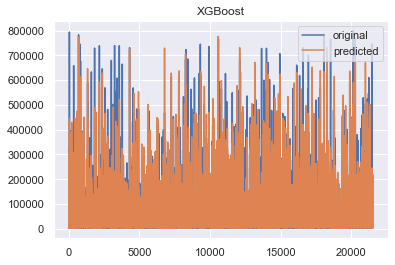

In [216]:
x_ax = range(len(y_val2))
plt.plot(x_ax, y_val2, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("XGBoost")
plt.legend()
plt.show()

In [226]:
from sklearn.metrics import r2_score

train_dataset = Pool(X_train2, y_train2) 
test_dataset = Pool(X_val2, y_val2)
modelCat = CatBoostRegressor(loss_function='RMSE')

grid = {'iterations': [200],
        'learning_rate': [0.03, 0.1,0.2],
        'depth': [ 4, 6, 8,10,12],
        'l2_leaf_reg': [0.2, 0.5,0.7, 1,]}
modelCat.grid_search(grid, train_dataset)

0:	learn: 70612.4234695	test: 72563.6290171	best: 72563.6290171 (0)	total: 8.69ms	remaining: 1.73s
1:	learn: 68935.9005436	test: 70843.9133211	best: 70843.9133211 (1)	total: 15.8ms	remaining: 1.56s
2:	learn: 67276.6084430	test: 69144.3094825	best: 69144.3094825 (2)	total: 22.6ms	remaining: 1.49s
3:	learn: 65723.8686330	test: 67555.4762098	best: 67555.4762098 (3)	total: 28.8ms	remaining: 1.41s
4:	learn: 64192.7478931	test: 65986.8365093	best: 65986.8365093 (4)	total: 35.2ms	remaining: 1.37s
5:	learn: 62701.8175337	test: 64463.9692927	best: 64463.9692927 (5)	total: 41ms	remaining: 1.33s
6:	learn: 61266.2773922	test: 62996.4480976	best: 62996.4480976 (6)	total: 47.8ms	remaining: 1.32s
7:	learn: 59891.9216748	test: 61586.4297381	best: 61586.4297381 (7)	total: 54.7ms	remaining: 1.31s
8:	learn: 58552.0464860	test: 60212.5360636	best: 60212.5360636 (8)	total: 60.4ms	remaining: 1.28s
9:	learn: 57241.9124747	test: 58851.9079311	best: 58851.9079311 (9)	total: 65.7ms	remaining: 1.25s
10:	learn: 5

{'params': {'depth': 4,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.7},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [231]:
pred = modelCat.predict(X_val2)
rmse = (np.sqrt(mean_squared_error(y_val2, pred)))
r2 = r2_score(y_val2, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 27800.65
R2: 0.80


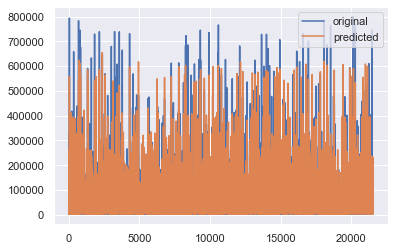

In [232]:
pred = modelCat.predict(X_val2)
x_ax = range(len(y_val2))
plt.plot(x_ax, y_val2, label="original")
plt.plot(x_ax, pred, label="predicted")
# plt.title("Cat")
plt.legend()
plt.show()

In [233]:
pred = modelCat.predict(df_test3)
pred

array([51794.71371655, 24094.28429381,  9005.27097116, ...,
        3886.64603101, 31991.26193464, 51018.66101954])

In [234]:
import csv
submission = []
i=0
fields = ["property_id","price"]
for value in df_test3["property_id"]:
  submission.append( [value, pred[i] ])
  i+=1
with open('notgenerico2.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(submission)